In [6]:
import numpy as np
import matplotlib.pyplot as plt

Lx = 1
Ly = 1
nx = 40
ny = 40

imin = 1
imax = imin + nx - 1
jmin = 1
jmax = jmin + ny - 1


x = np.zeros(jmax + 2)
y = np.zeros(jmax + 2)
x[imin: imax + 2] = np.linspace(0, Lx, nx + 1, endpoint=True)
y[jmin: jmax + 2] = np.linspace(0, Ly, ny + 1, endpoint=True)
u = np.zeros((imax + 2, jmax + 2))
v = np.zeros((imax + 2, jmax + 2))


dt = 0.001
nu = .1
rho = 1.


dx = x[imin + 1] - x[imin]
dy = y[jmin + 1] - y[jmin]
dxi = 1 / dx
dyi = 1 / dy

In [7]:
def laplace_matrix(nx, ny, dxi, dyi):
    Dx = np.diag(np.ones(nx)) * 2 - np.diag(np.ones(nx - 1), 1) - np.diag(np.ones(nx - 1), -1)
    Dx[0, 0] = 1
    Dx[-1, -1] = 1
    Ix = np.diag(np.ones(ny))
    Dy = np.diag(np.ones(ny)) * 2 - np.diag(np.ones(ny - 1), 1) - np.diag(np.ones(ny - 1), -1)
    Dy[0, 0] = 1
    Dy[-1, -1] = 1
    Iy = np.diag(np.ones(nx))
    L = np.kron(Ix, Dx) * dxi ** 2 + np.kron(Dy, Iy) * dyi ** 2
    return L

L = laplace_matrix(nx, ny, dxi, dyi)

Ap Matrix Condition Number =  2.618677177489212e+16


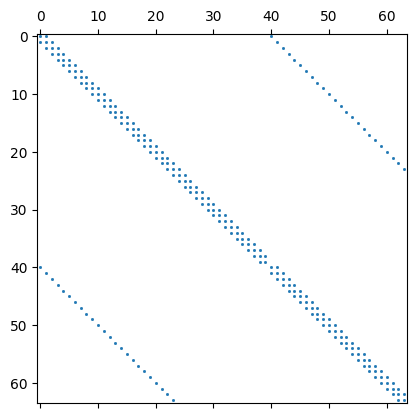

In [9]:
# Check sparse pattern
print("Ap Matrix Condition Number = ", np.linalg.cond(L))
plt.spy(L[0:64, 0:64], markersize=1)
plt.show()

In [ ]:
    us = u.copy()


    I = slice(imin + 1, imax + 1)
    Ib = slice(imin, imax)
    If = slice(imin + 2, imax + 2)


    J = slice(jmin, jmax + 1)
    Jb = slice(jmin - 1, jmax)
    Jf = slice(jmin + 1, jmax + 2)


    v_here = 0.25 * (v[Ib, J] + v[Ib, Jf] + v[I, J] + v[I, Jf])
    us[I, J] = u[I, J] + dt * (
            nu * (u[Ib, J] - 2 * u[I, J] + u[If, J]) * dxi ** 2
            + nu * (u[I, Jb] - 2 * u[I, J] + u[I, Jf]) * dyi ** 2
            - v_here * (u[I, Jf] - u[I, Jb]) * 0.5 * dyi
            - u[I, J] * (u[If, J] - u[Ib, J]) * 0.5 * dxi
    )

In [ ]:
    vs = v.copy()
    I = slice(imin, imax + 1)
    Ib = slice(imin - 1, imax)
    If = slice(imin + 1, imax + 2)


    J = slice(jmin + 1, jmax + 1)
    Jb = slice(jmin, jmax)
    Jf = slice(jmin + 2, jmax + 2)


    u_here = 0.25 * (u[I, Jb] + u[I, J] + u[If, Jb] + u[If, J])
    vs[I, J] = v[I, J] + dt * (
            nu * (v[Ib, J] - 2 * v[I, J] + v[If, J]) * dxi ** 2
            + nu * (v[I, Jb] - 2 * v[I, J] + v[I, Jf]) * dyi ** 2
            - u_here * (v[If, J] - v[Ib, J]) * 0.5 * dxi
            - v[I, J] * (v[I, Jf] - v[I, Jb]) * 0.5 * dyi
    )

In [ ]:
    Rn = -rho / dt * ((us[imin + 1: imax + 2, jmin: jmax + 1]
                       - us[imin: imax + 1, jmin: jmax + 1]) * dxi
                      + (vs[imin: imax + 1, jmin + 1: jmax + 2]
                         - vs[imin: imax + 1, jmin: jmax + 1]) * dyi)
    R = Rn.T.ravel()
    pv = np.linalg.solve(L, R)
    pn = pv.reshape(ny, nx).T
    p = np.zeros((imax + 1, jmax + 1))
    p[1:, 1:] = pn

In [ ]:
u[imin + 1: imax + 1, jmin: jmax + 1] = us[imin + 1: imax + 1, jmin: jmax + 1] - dt / rho * (
            p[imin + 1: imax + 1, jmin: jmax + 1] - p[imin: imax, jmin: jmax + 1]) * dxi
    v[imin: imax + 1, jmin + 1: jmax + 1] = vs[imin: imax + 1, jmin + 1: jmax + 1] - dt / rho * (
            p[imin: imax + 1, jmin + 1: jmax + 1] - p[imin: imax + 1, jmin: jmax]) * dyi


In [ ]:
def boundary_condition(u, v):
    u[imin, jmin - 1:jmax + 1] = 0
    u[imax + 1, jmin - 1:jmax + 1] = 0
    u[imin: imax + 2, jmin - 1] = -u[imin: imax + 2, jmin]
    u[imin: imax + 2, jmax + 1] = 2 - u[imin: imax + 2, jmax]


    v[imin - 1: imax + 2, jmin] = 0.
    v[imin - 1: imax + 2, jmax + 1] = 0.
    v[imin - 1, jmin:jmax + 1] = -v[imin, jmin:jmax + 1]
    v[imax + 1, jmin:jmax + 1] = -v[imax, jmin:jmax + 1]

### Main Algorithm

In [3]:
res_hist = []

iteration = 1
# max_iteration = 2    # for debug
while iteration <= max_iteration and max_res > tol:
    iteration += 1
    
    # Solve u and v momentum equations for intermediate velocity 
    u_star, d_u = u_momentum(imax, jmax, dx, dy, rho, mu, u, v, p_star, velocity, alpha_u)
    v_star, d_v = v_momentum(imax, jmax, dx, dy, rho, mu, u, v, p_star, alpha_u)

    u_old = u.copy()
    v_old = v.copy()

    # Calculate rhs vector of the Pressure Poisson matrix 
    rhsp = get_rhs(imax, jmax, dx, dy, rho, u_star, v_star)
    
    # Form the Pressure Poisson coefficient matrix 
    Ap = get_coeff_mat(imax, jmax, dx, dy, rho, d_u, d_v)
    
    # Solve pressure correction implicitly and update pressure
    p, p_prime = pressure_correct(imax, jmax, rhsp, Ap, p_star, alpha_p)
    
    # Update velocity based on pressure correction
    u, v = update_velocity(imax, jmax, u_star, v_star, p_prime, d_u, d_v, velocity)
    
    # Check if velocity field is divergence free
    div = check_divergence_free(imax, jmax, dx, dy, u, v)

    p_star = p.copy()              # use p as p_star for the next iteration

    # Find maximum residual in the domain
    v_res = np.abs(v - v_old)
    u_res = np.abs(u - u_old)
    max_res_u = np.max(u_res)
    max_res_v = np.max(v_res)
    max_res = max(max_res_u, max_res_v)
    res_hist.append(max_res)

    # Check for convergence  
    if (iteration % 50) == 0:
        print(f"Iteration = {iteration}; Residual = {max_res}")
    
    if max_res > 2:
        print("not going to converge!")
        break

Iteration = 50; Residual = 0.003448861316047269
Iteration = 100; Residual = 0.0011876546378165043
Iteration = 150; Residual = 0.0005480380418994846
Iteration = 200; Residual = 0.000289225699769656
Iteration = 250; Residual = 0.0001613245452103257
Iteration = 300; Residual = 9.209443521484423e-05
Iteration = 350; Residual = 5.2945979328769543e-05
Iteration = 400; Residual = 3.0504836671239877e-05
Iteration = 450; Residual = 1.761363031166363e-05
Iteration = 500; Residual = 1.0174837544923987e-05


### Visualization

Final Iteration = 502; Residual = 9.953621186276074e-06


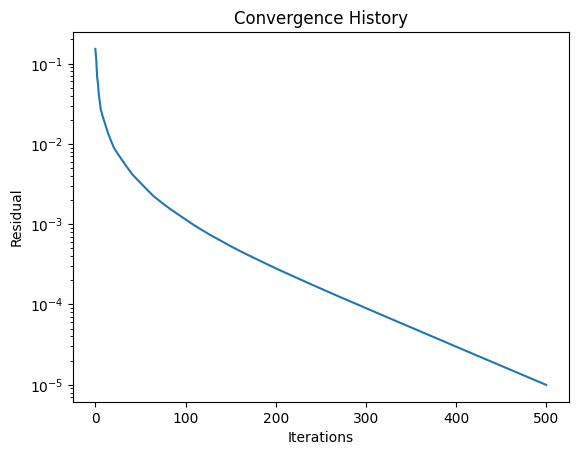

In [4]:
# Final residual        
print(f"Final Iteration = {iteration}; Residual = {max_res}")
plt.plot(np.arange(iteration)[0:-1], res_hist)
plt.xlabel("Iterations")
plt.ylabel("Residual")
plt.title("Convergence History")
# plt.grid()
ax = plt.gca()
ax.set_yscale("log")

Ap Matrix Condition Number =  76518.47446407289


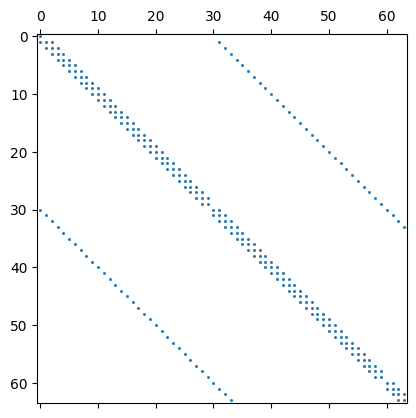

In [5]:
# Check sparse pattern
print("Ap Matrix Condition Number = ", np.linalg.cond(Ap))
plt.spy(Ap[0:64, 0:64], markersize=1)
plt.show()

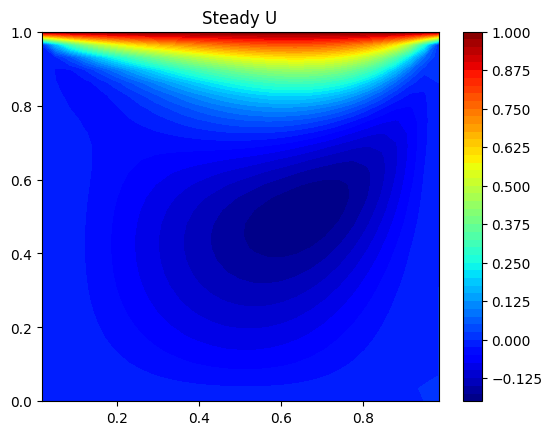

In [6]:
X, Y = np.meshgrid(x, y)
plt.figure()
plt.contourf(X, Y, u[1:imax,:].T, 50, cmap='jet')
plt.colorbar()
# plt.axis([0, 1, 0, 1])
plt.title("Steady U")
plt.show()

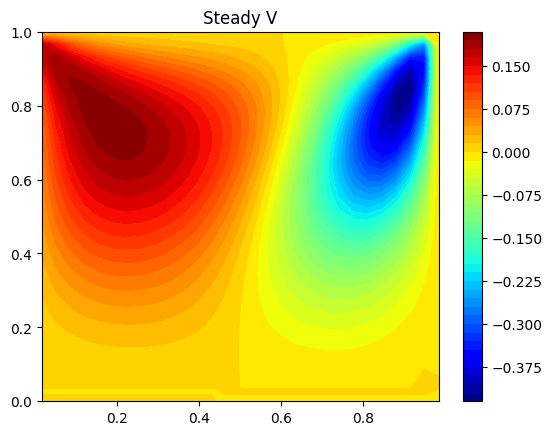

In [7]:
plt.figure()
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, v[1:imax, 0:jmax].T, 50, cmap='jet')
plt.colorbar()
# plt.axis([0, 1, 0, 1])
plt.title("Steady V")
plt.show()

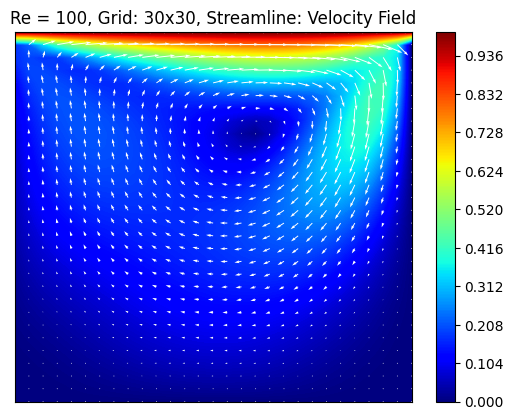

In [8]:
plt.figure()
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, np.sqrt(u[1:imax,:].T**2 + v[1:imax, 0:jmax].T**2), 300, cmap='jet')
plt.colorbar()
# skip = (slice(None, None, 2), slice(None, None, 2))
plt.quiver(X, Y, u[1:imax,:].T, v[1:imax, 0:jmax].T, color='w')
plt.title('Re = {0}, Grid: {1}x{2}, Streamline: Velocity Field'.format(Re, imax, jmax))
plt.xticks([])
plt.yticks([])
plt.savefig("./Benchmark/Re{0}/Stream_Re{0}_Grid{1}x{2}.png".format(Re, imax, jmax), dpi=500)
plt.show()

/Users/jacksong/opt/anaconda3/envs/QCFD_env/lib/python3.8/site-packages/matplotlib/patches.py:3331: RuntimeWarning: invalid value encountered in scalar divide
  cos_t, sin_t = head_length / head_dist, head_width / head_dist


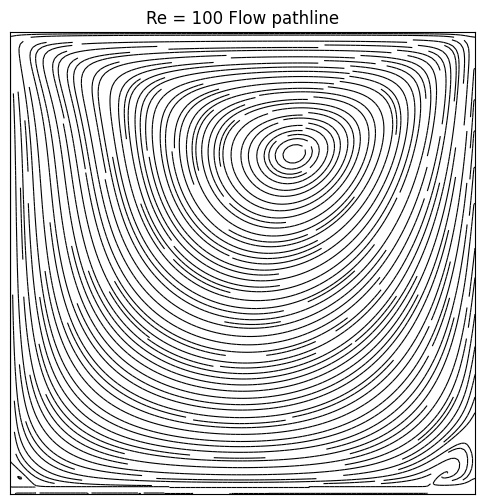

In [34]:
plt.figure(figsize=(6,6))
X, Y = np.meshgrid(x, y)
plt.streamplot(X, Y, u[1:imax,:].T, v[1:imax, 0:jmax].T, density=3, linewidth=0.8, arrowsize=0., color='k')
plt.title("Re = {0} Flow pathline".format(Re))
plt.xticks([])
plt.yticks([])
plt.show()

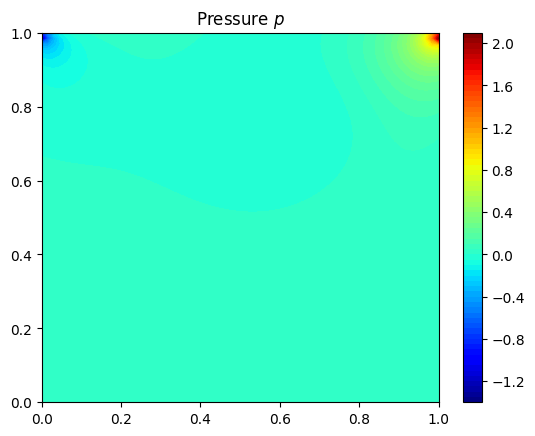

In [35]:
X, Y = np.meshgrid(y, y)
plt.figure()
plt.contourf(X, Y, p.T, 80, cmap='jet')
plt.colorbar()
# plt.axis([0, 1, 0, 1])
plt.title('Pressure $p$')
plt.show()

### Benchmark with literature data

Ghia, U. K. N. G., Kirti N. Ghia, and C. T. Shin. "High-Re solutions for incompressible flow using the Navier-Stokes equations and a multigrid method." Journal of computational physics 48.3 (1982): 387-411.

In [36]:
GhiaU = np.loadtxt('./benchmark/GhiaU.txt', skiprows=1)
GhiaV = np.loadtxt('./benchmark/GhiaV.txt', skiprows=1)
y_Ghia = GhiaU[:, 0]
x_Ghia = GhiaV[:, 0]

In [37]:
# Understand what's inside the benchmark data
import pandas as pd
# pd.set_option('display.max_columns', None)
df = pd.read_table("./benchmark/GhiaU.txt", skiprows=0, delimiter='\r')
print(df)

   # Ghia, U. K. N. G., Ghia, K. N., & Shin, C. T. (1982). 
0   # High-Re solutions for incompressible flow us...      
1   # Journal of computational physics, 48(3), 387...      
2                                                   #      
3                                           # TABLE I      
4   # Results for $u$-velocity along Vertical Line...      
5   #---------------------------------------------...      
6              #                                   Re      
7   #       --------------------------------------...      
8   #  y      100      400      1000     3200     ...      
9   #---------------------------------------------...      
10  1.0000  1.00000  1.00000  1.00000  1.00000  1....      
11  0.9766  0.84123  0.75837  0.65928  0.53236  0....      
12  0.9688  0.78871  0.68439  0.57492  0.48296  0....      
13  0.9609  0.73722  0.61756  0.51117  0.46547  0....      
14  0.9531  0.68717  0.55892  0.46604  0.46101  0....      
15  0.8516  0.23151  0.29093  0.33304  0

#### Re = 100

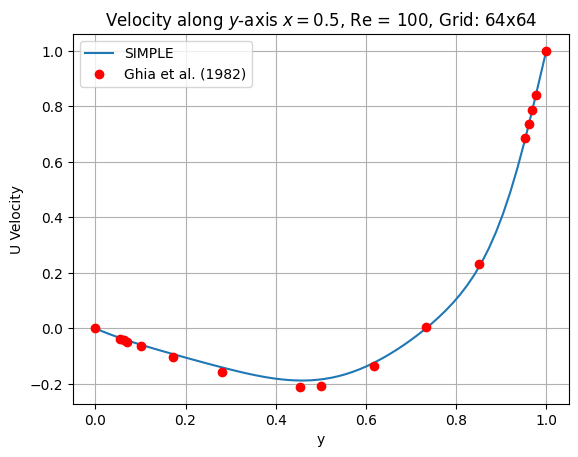

In [38]:
xmid_idx = int(imax/2-1)      # only works for even number
plt.plot(y, u[xmid_idx,:].T, label="SIMPLE")
plt.plot(y_Ghia, GhiaU[:, 1], 'ro', label = "Ghia et al. (1982)")
plt.grid()
plt.xlabel("y")
plt.ylabel("U Velocity")
plt.title("Velocity along $y$-axis $x=0.5$, Re = {0}, Grid: {1}x{2}".format(Re, imax, jmax))
plt.legend()
plt.savefig("./Benchmark/Re{0}/UBench_Re{0}_Grid{1}x{2}.png".format(Re, imax, jmax), dpi=500)

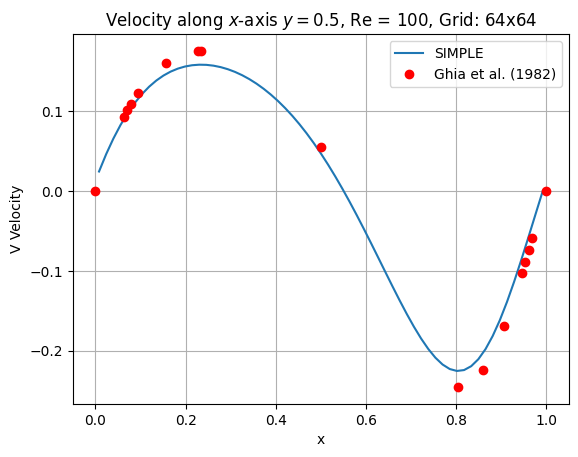

In [39]:
ymid_lidx = int(imax/2-1)      # only works for even number
v_profile = (v[1:imax, ymid_lidx].T + v[1:imax, ymid_lidx+1].T)/2
plt.plot(x, v_profile, label="SIMPLE")
plt.plot(x_Ghia, GhiaV[:, 1], 'ro', label = "Ghia et al. (1982)")
plt.grid()
plt.xlabel("x")
plt.ylabel("V Velocity")
plt.title("Velocity along $x$-axis $y=0.5$, Re = {0}, Grid: {1}x{2}".format(Re, imax, jmax))
plt.legend()
plt.savefig("./Benchmark/Re{0}/VBench_Re{0}_Grid{1}x{2}.png".format(Re, imax, jmax), dpi=500)

#### Re = 400

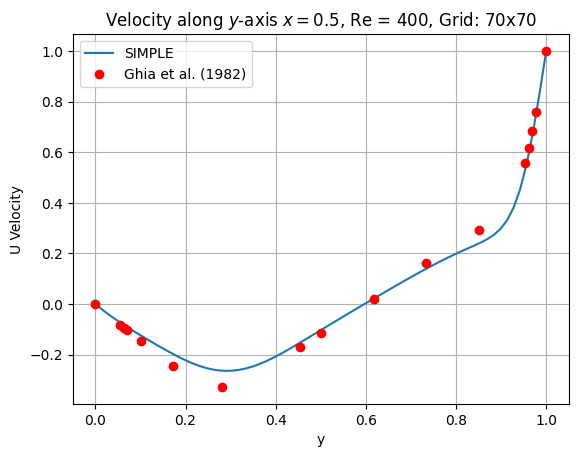

In [105]:
xmid_idx = int(imax/2-1)      # only works for even number
plt.plot(y, u[xmid_idx,:].T, label="SIMPLE")
plt.plot(y_Ghia, GhiaU[:, 2], 'ro', label = "Ghia et al. (1982)")
plt.grid()
plt.xlabel("y")
plt.ylabel("U Velocity")
plt.title("Velocity along $y$-axis $x=0.5$, Re = {0}, Grid: {1}x{2}".format(Re, imax, jmax))
plt.legend()
plt.savefig("./Benchmark/Re{0}/UBench_Re{0}_Grid{1}x{2}.png".format(Re, imax, jmax), dpi=500)

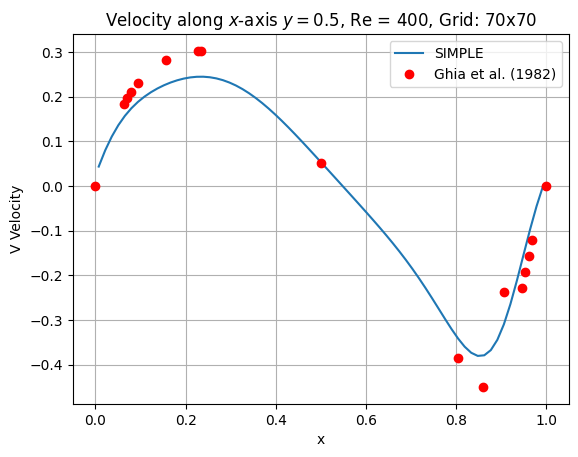

In [106]:
ymid_lidx = int(imax/2-1)      # only works for even number
v_profile = (v[1:imax, ymid_lidx].T + v[1:imax, ymid_lidx+1].T)/2
plt.plot(x, v_profile, label="SIMPLE")
plt.plot(x_Ghia, GhiaV[:, 2], 'ro', label = "Ghia et al. (1982)")
plt.grid()
plt.xlabel("x")
plt.ylabel("V Velocity")
plt.title("Velocity along $x$-axis $y=0.5$, Re = {0}, Grid: {1}x{2}".format(Re, imax, jmax))
plt.legend()
plt.savefig("./Benchmark/Re{0}/VBench_Re{0}_Grid{1}x{2}.png".format(Re, imax, jmax), dpi=500)

http://nmprogramming.blogspot.com/2015/12/2d-lid-driven-cavity-problem-using.html